# Phase 1: Baseline Model Training (Optimized & Balanced)

This notebook implements the baseline training for the **OP-ECOM** project. It establishes a comparison between Logistic Regression and XGBoost on the UCI Online Shoppers Purchasing Intention dataset.

### 💎 Key Features:
1. **80/10/10 Split**: Training (80%), Testing (10%), and Validation (10%).
2. **Training Set Balancing**: Manual upsampling to ensure the AI learns from an equal number of buyers and non-buyers.
3. **Premium Visuals**: Lapis Lazuli themed performance charts.

In [13]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)
import xgboost as xgb
import joblib
import json
from datetime import datetime
from sklearn.utils import resample

# Premium Styling (لاجوردی)
plt.style.use('seaborn-v0_8-whitegrid')
PRIMARY_COLOR = '#1E4FA8'
SECONDARY_COLOR = '#E8F0FF'

# Paths
DATA_PATH = "../data/raw/online_shoppers_intention.csv"
MODELS_PATH = "../backend/models"
REPORTS_PATH = "../reports/metrics"

os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(REPORTS_PATH, exist_ok=True)

print("✅ Environment Ready!")

✅ Environment Ready!


## 1. Data Loading & Distribution
We start by loading the UCI dataset and verifying the class imbalance.

Dataset shape: (12330, 18)


C:\Users\khair\AppData\Local\Temp\ipykernel_14752\1646409629.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Revenue', data=df, palette=[SECONDARY_COLOR, PRIMARY_COLOR])


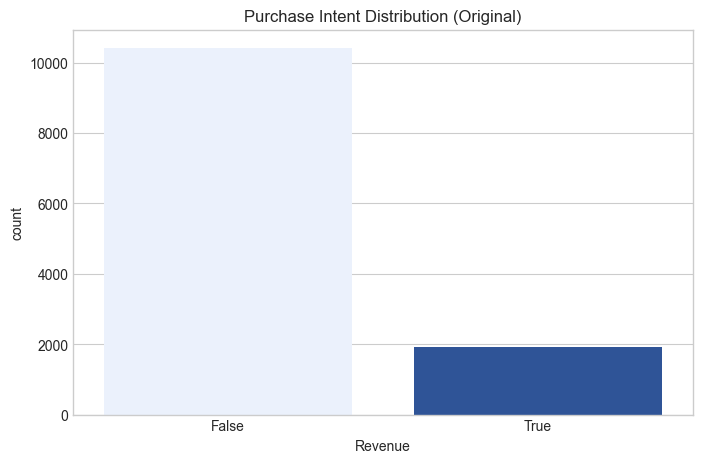

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [14]:
df = pd.read_csv(DATA_PATH)
print(f"Dataset shape: {df.shape}")

# Target distribution visualization
plt.figure(figsize=(8, 5))
sns.countplot(x='Revenue', data=df, palette=[SECONDARY_COLOR, PRIMARY_COLOR])
plt.title('Purchase Intent Distribution (Original)')
plt.show()

df.head()

## 2. Advanced Preprocessing
Implementing the 80/10/10 split and balancing the training set via upsampling.

In [15]:
X = df.drop('Revenue', axis=1)
y = df['Revenue'].astype(int)

# 1. Features Handling
categorical_cols = ['Month', 'VisitorType', 'Weekend']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# 2. 80/10/10 Split Strategy
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 3. Scaling
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_val_scaled = X_val.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])

# 4. Training Set Balancing (Oversampling)
train_data = pd.concat([X_train_scaled, y_train], axis=1)
not_buy = train_data[train_data.Revenue == 0]
buy = train_data[train_data.Revenue == 1]

buy_upsampled = resample(buy, replace=True, n_samples=len(not_buy), random_state=42)
train_balanced = pd.concat([not_buy, buy_upsampled])

X_train_final = train_balanced.drop('Revenue', axis=1)
y_train_final = train_balanced.Revenue

print(f"✅ Preprocessing Complete!")
print(f"   → Training: {len(X_train_final)} (Balanced)")
print(f"   → Test:     {len(X_test)}")
print(f"   → Val:      {len(X_val)}")

✅ Preprocessing Complete!
   → Training: 16676 (Balanced)
   → Test:     1233
   → Val:      1233


## 3. Training & Evaluation Pipeline
We train both models and collect metrics for comparison.

In [16]:
# 3.1 Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_final, y_train_final)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = lr_model.predict(X_test_scaled)

# 3.2 XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_final, y_train_final)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Metric collection
def get_metrics(name, y_true, y_pred, y_prob):
    return {
        'model': name,
        'auc_roc': roc_auc_score(y_true, y_prob),
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

results = [
    get_metrics('Logistic Regression', y_test, y_pred_lr, y_prob_lr),
    get_metrics('XGBoost', y_test, y_pred_xgb, y_prob_xgb)
]

pd.DataFrame(results).set_index('model')

,auc_roc,f1,precision,recall
model,,,,
Logistic Regression,0.897197,0.645880,0.562016,0.759162
XGBoost,0.922004,0.685851,0.632743,0.748691


## 4. Visual Comparison
Let's see the performance spread and feature importance.

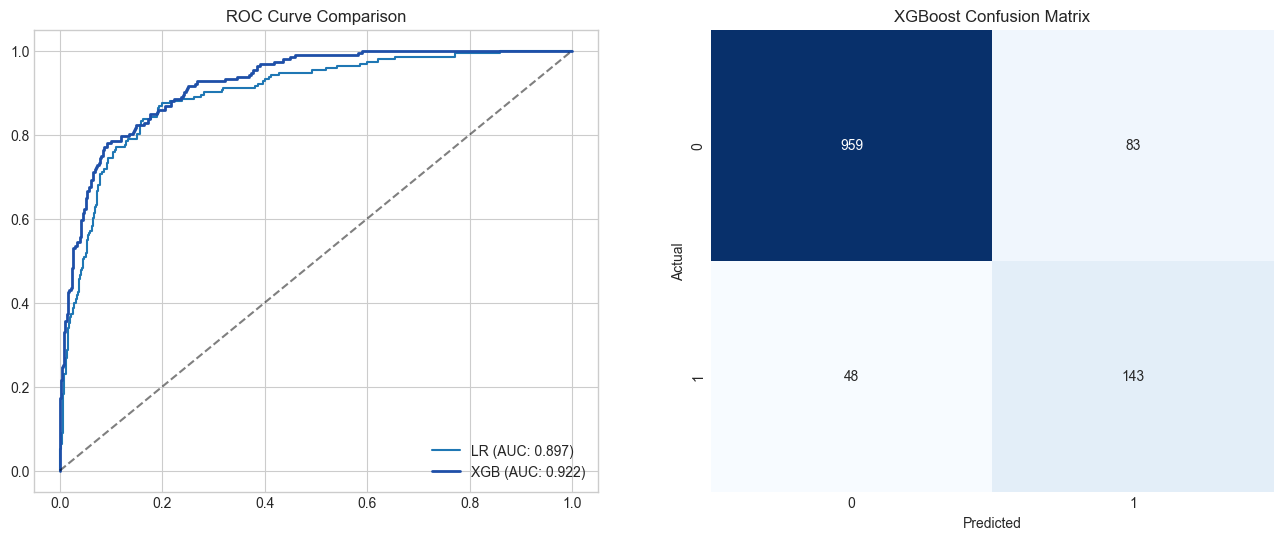

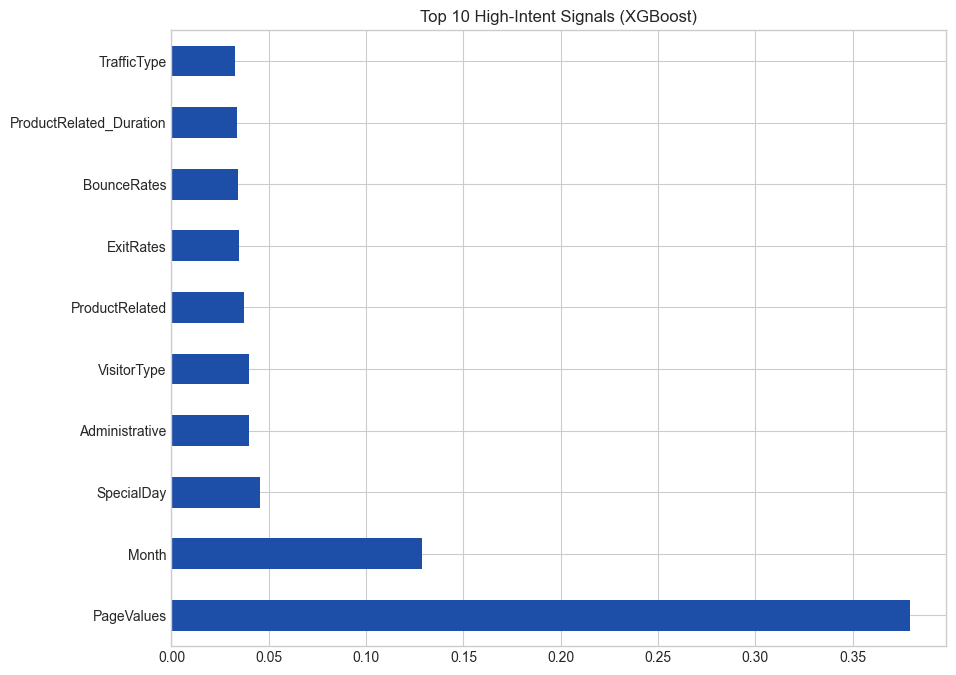

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
ax1.plot(fpr_lr, tpr_lr, label='LR (AUC: {:.3f})'.format(results[0]['auc_roc']))
ax1.plot(fpr_xgb, tpr_xgb, label='XGB (AUC: {:.3f})'.format(results[1]['auc_roc']), color=PRIMARY_COLOR, linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_title('ROC Curve Comparison')
ax1.legend()

# Confusion Matrix (XGBoost)
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=False)
ax2.set_title('XGBoost Confusion Matrix')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
pd.Series(xgb_model.feature_importances_, index=X.columns).nlargest(10).plot(kind='barh', color=PRIMARY_COLOR)
plt.title('Top 10 High-Intent Signals (XGBoost)')
plt.show()

## 5. Artifact Archival
Saving the trained baseline state for the backend.

In [18]:
joblib.dump(xgb_model, os.path.join(MODELS_PATH, 'xgboost.joblib'))
joblib.dump(scaler, os.path.join(MODELS_PATH, 'scaler.joblib'))
joblib.dump(label_encoders, os.path.join(MODELS_PATH, 'label_encoders.joblib'))

with open(os.path.join(REPORTS_PATH, 'baseline_metrics.json'), 'w') as f:
    json.dump({'timestamp': datetime.now().isoformat(), 'models': results}, f, indent=2)

print("✅ All baseline models and reports archived!")

✅ All baseline models and reports archived!
